In [1]:
 from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Validation/F/167.jpg  
  inflating: dataset/Validation/F/168.jpg  
  inflating: dataset/Validation/F/169.jpg  
  inflating: dataset/Validation/F/17.jpg  
  inflating: dataset/Validation/F/170.jpg  
  inflating: dataset/Validation/F/171.jpg  
  inflating: dataset/Validation/F/172.jpg  
  inflating: dataset/Validation/F/173.jpg  
  inflating: dataset/Validation/F/174.jpg  
  inflating: dataset/Validation/F/175.jpg  
  inflating: dataset/Validation/F/176.jpg  
  inflating: dataset/Validation/F/177.jpg  
  inflating: dataset/Validation/F/178.jpg  
  inflating: dataset/Validation/F/179.jpg  
  inflating: dataset/Validation/F/18.jpg  
  inflating: dataset/Validation/F/180.jpg  
  inflating: dataset/Validation/F/181.jpg  
  inflating: dataset/Validation/F/182.jpg  
  inflating: dataset/Validation/F/183.jpg  
  inflating: dataset/Validation/F/184.jpg  
  inflating: dataset/Validation/F/185.jpg  
  inflating: dataset/Valida

In [10]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import tqdm
import IPython

In [4]:
train_directory = '../content/dataset/Train' 
val_directory = '../content/dataset/Validation'

In [5]:
def set_device():

  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("cpu!")
  else:
    print("GPU")

  return device
DEVICE = set_device()

GPU


In [6]:
# Prepare train and test dataloader
transform_image = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5] )
    ])
Batch_size = 64
train_data = torchvision.datasets.ImageFolder(root=train_directory, transform=transform_image)
train_data_loader = data.DataLoader(train_data, batch_size=Batch_size, shuffle=True,  num_workers=0)
test_data = torchvision.datasets.ImageFolder(root=val_directory, transform=transform_image)
test_data_loader  = data.DataLoader(test_data, batch_size=Batch_size, shuffle=True, num_workers=0) 

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # moving data to gpu
        self.device = torch.device(DEVICE)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4096, 256)
        # output of 39 for each class
        self.fc2 = nn.Linear(256, 39)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
net = Net()
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=39, bias=True)
)

In [8]:
# using cross entropy loss as loss function
criterion = nn.CrossEntropyLoss()
# nadam as optimizer
optimizer = optim.NAdam(net.parameters(), lr=0.002)

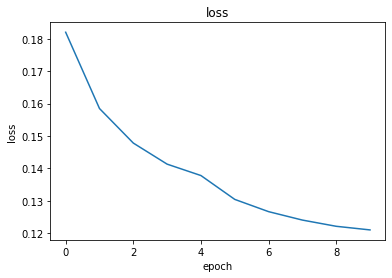

Starting Epoch: 11...
Epoch: 11, Mini-Batches Completed: 5000, Loss: 0.112, Test Accuracy = 94.481%


KeyboardInterrupt: ignored

In [11]:
# loop over the traing dataset multiple times ( 2 times because of the colab limitations)
epochs = 15

# some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# loop for Iterating through epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')
    nsamples = 100000
    # We keep adding our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator, Each cycle is a minibatch
    for i, data in enumerate(train_data_loader, 0):
        # split dataset (again for hardware and colab limitations)
        if i > nsamples:
            break
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Clearing the gradients before training by setting to zero
        optimizer.zero_grad()

        # Forward then backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Geting Loss 
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients and weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 5000 == 4999:    # show our loss every 5000 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in test_data_loader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 5000
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    print(f"number of epochs : {epoch_log}")
    loss_log.append(actual_loss)
    print(f"loss : {loss_log}")
    accuracy_log.append(accuracy)
    print(f"accuracy : {accuracy_log}")
    plt.plot(accuracy_log)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Handwritten prediction accuracy')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    plt.plot(loss_log)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    plt.close()

print('Finished Training')

In [12]:
print(accuracy_log)

[94.00639318060735, 94.30385366719943, 94.72118629017936, 94.08630793819925, 94.61907298881194, 94.76558337773042, 94.32161250221985, 94.78334221275084, 94.75670396022021, 94.03303143313799]


In [14]:
print(loss_log)

[0.18200997209735215, 0.15847842613784596, 0.14782121808947996, 0.14131648679915815, 0.137799259262532, 0.13044196363538504, 0.12666256808275356, 0.12406080986764283, 0.12214257781989872, 0.12102540792780929]


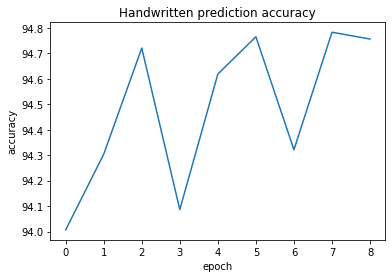

In [15]:
plt.plot(accuracy_log[:-1])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Handwritten prediction accuracy')
IPython.display.clear_output(wait=True)
IPython.display.display(plt.gcf())
plt.close()